In [8]:
# 1. Load Data

import h5py
import numpy as np

with h5py.File('../data/bird_spectrograms_splits.hdf5', 'r') as f:
    X_train = f['X_train'][:]
    y_train = f['y_train'][:]
    X_val = f['X_val'][:]
    y_val = f['y_val'][:]
    X_test = f['X_test'][:]
    y_test = f['y_test'][:]

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")


Train: (1074, 343, 256), Validation: (231, 343, 256), Test: (231, 343, 256)
Number of classes: 12


In [9]:
# 2. Reshape Data for CNN (add channel dimension)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]


In [10]:
# 3. One-Hot Encode Labels
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


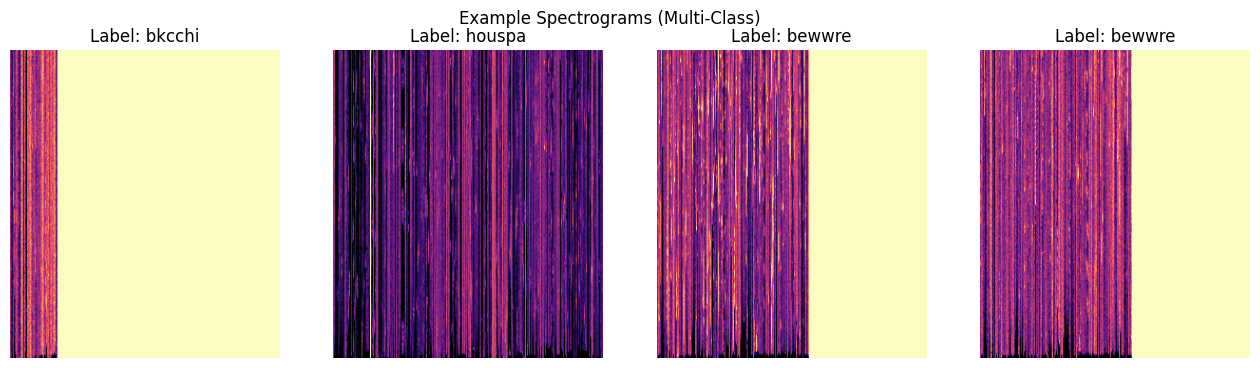

In [11]:
# 4. Visualize Example Spectrograms
import matplotlib.pyplot as plt

species_labels = [
    'amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
    'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa'
]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train))
    label = y_train[idx]
    ax.imshow(X_train[idx], aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"Label: {species_labels[label]}")
    ax.axis('off')
plt.suptitle("Example Spectrograms (Multi-Class)")
plt.show()


In [12]:
# 5. Build the CNN Model (Matching Diagram)
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train_cnn.shape[1:]

model = models.Sequential([
    layers.Reshape((343, 256, 1), input_shape=input_shape),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mae']
)

model.summary()


c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 343, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 343, 256, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 171, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 171, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 85, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,620 (25.86 KB)

 Trainable params: 6,620 (25.86 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 6. Train the Model
history = model.fit(
    X_train_cnn, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val_cat)
)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.0807 - loss: 2.4860 - mae: 0.1528 - val_accuracy: 0.1688 - val_loss: 2.4774 - val_mae: 0.1527
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.1290 - loss: 2.4739 - mae: 0.1526 - val_accuracy: 0.1775 - val_loss: 2.4414 - val_mae: 0.1521
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.1593 - loss: 2.4194 - mae: 0.1516 - val_accuracy: 0.1688 - val_loss: 2.2777 - val_mae: 0.1483
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.1509 - loss: 2.2762 - mae: 0.1477 - val_accuracy: 0.2944 - val_loss: 1.9764 - val_mae: 0.1401
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.2395 - loss: 1.9880 - mae: 0.1390 - val_accuracy: 0.3636 - val_loss: 1.6853 - val_mae: 0.1324
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.2464 - loss: 1.8554 - mae: 0.1352 - val_accuracy: 0.4113 - val_loss: 1.5430 - val_mae: 0.1273
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s

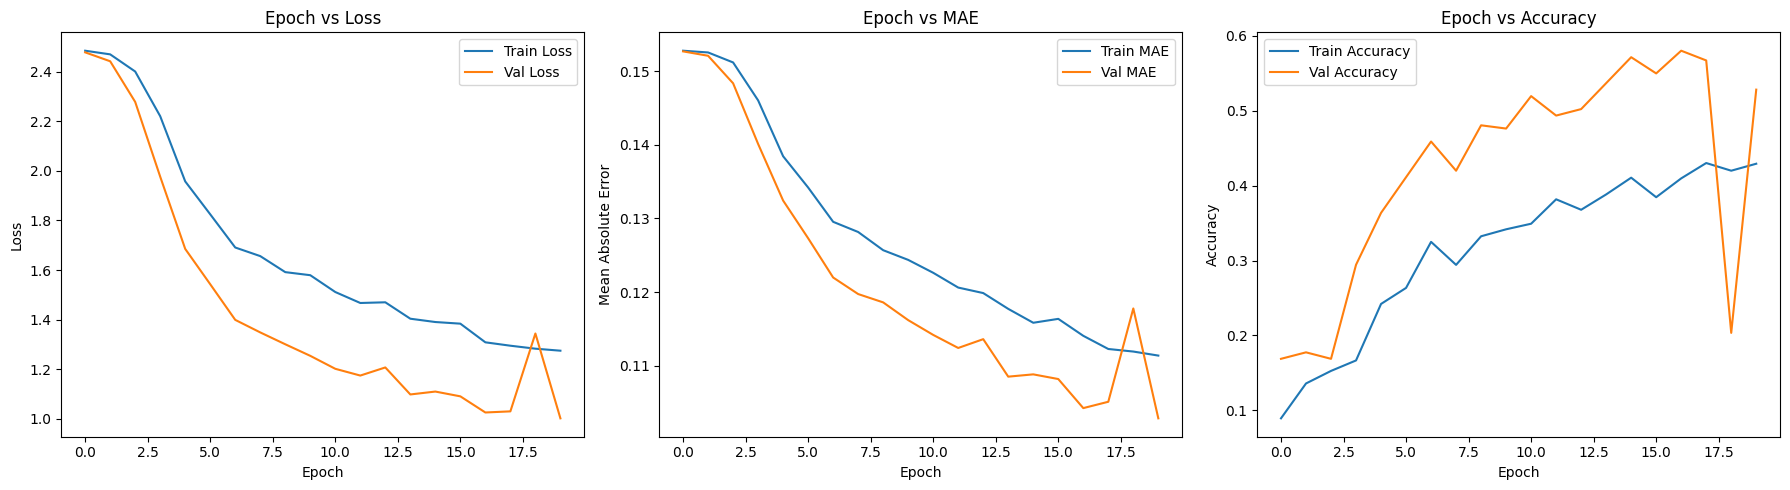

In [14]:
# 7. Plot Loss, MAE, and Accuracy Curves
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

mae_key = 'mae' if 'mae' in history.history else 'mean_absolute_error'
val_mae_key = 'val_mae' if 'val_mae' in history.history else 'val_mean_absolute_error'
plt.subplot(1, 3, 2)
plt.plot(history.history[mae_key], label='Train MAE')
plt.plot(history.history[val_mae_key], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Epoch vs MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# 8. Evaluate the Model
test_loss, test_acc, test_mae = model.evaluate(X_test_cnn, y_test_cat, verbose=2)
print(f"Test accuracy: {test_acc:.3f}, Test MAE: {test_mae:.3f}")


8/8 - 0s - 30ms/step - accuracy: 0.5498 - loss: 1.0186 - mae: 0.1031
Test accuracy: 0.550, Test MAE: 0.103


In [16]:
# 9. Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(X_test_cnn), axis=1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=species_labels))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Confusion Matrix:
[[12  0  0  0  0  6  0  0  0  0  0  1]
 [ 0 10  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 19  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  9  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0 20  0  0]
 [ 1  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 19  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  5]]

Classification Report:
              precision    recall  f1-score   support

      amecro       0.92      0.63      0.75        19
      amerob       1.00      0.53      0.69        19
      bewwre       0.00      0.00      0.00        19
      bkcchi       0.51      1.00      0.68        20
      daejun       1.00      0.53      0.69        19
      houfin       0.39      0.68      0.50        19
      houspa       0.00      0.00      0.00        20
      norfli      

c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_18 (Reshape)            │ (None, 343, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 343, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 171, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 171, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 85, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 85, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 42, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,732 (432.55 KB)

 Trainable params: 110,732 (432.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.1075 - loss: 2.4744 - mae: 0.1526 - val_accuracy: 0.1645 - val_loss: 2.1813 - val_mae: 0.1468
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.2193 - loss: 2.0074 - mae: 0.1408 - val_accuracy: 0.4199 - val_loss: 1.4230 - val_mae: 0.1229
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.3247 - loss: 1.5540 - mae: 0.1250 - val_accuracy: 0.4892 - val_loss: 1.1923 - val_mae: 0.1120
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.4098 - loss: 1.3416 - mae: 0.1149 - val_accuracy: 0.6320 - val_loss: 1.0014 - val_mae: 0.1025
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.4182 - loss: 1.2685 - mae: 0.1103 - val_accuracy: 0.5455 - val_loss: 1.0063 - val_mae: 0.1030
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4556 - loss: 1.2021 - mae: 0.1072 - val_accuracy: 0.5584 - val_loss: 1.0346 - val_mae: 0.1030
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step

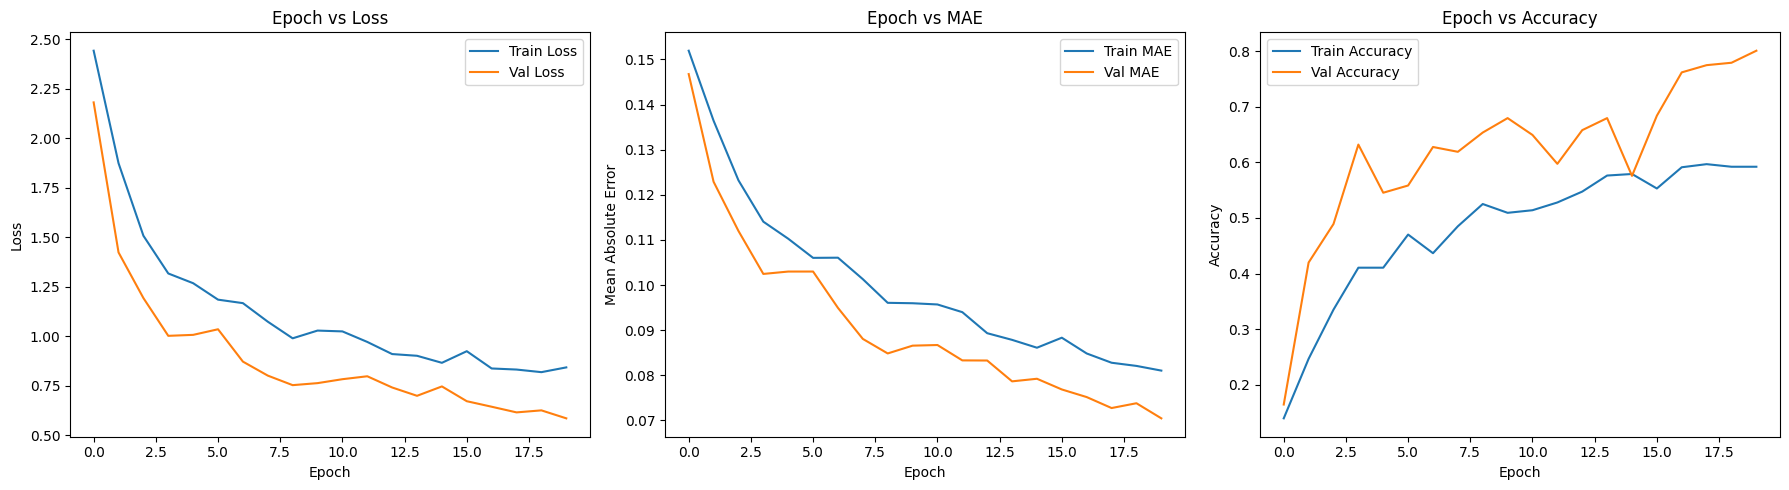

8/8 - 4s - 463ms/step - accuracy: 0.8225 - loss: 0.5848 - mae: 0.0703
Test accuracy: 0.823, Test MAE: 0.070
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step
Confusion Matrix:
[[19  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  4  0  0  0  0]
 [ 0  0  1  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  2  0  0  0  0  0 17]]

Classification Report:
              precision    recall  f1-score   support

      amecro       1.00      1.00      1.00        19
      amerob       1.00      1.00      1.00        19
      bewwre       0.56      1.00      0.72        19
      bkcchi       1.00      0.80      0.89        20
      daejun       1.00      0.95      0.97        19
      houfin     

c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mohdk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [37]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Load Data
with h5py.File('../data/bird_spectrograms_splits.hdf5', 'r') as f:
    X_train = f['X_train'][:]
    y_train = f['y_train'][:]
    X_val = f['X_val'][:]
    y_val = f['y_val'][:]
    X_test = f['X_test'][:]
    y_test = f['y_test'][:]

num_classes = len(np.unique(y_train))
species_labels = [
    'amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
    'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa'
]

# 2. Reshape Data (add channel dimension)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# 3. One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# 4. Build Model (matches your diagram)
input_shape = X_train_cnn.shape[1:]
model = models.Sequential([
    layers.Reshape((343, 256, 1), input_shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mae']
)

model.summary()


# 5. Train Model
history = model.fit(
    X_train_cnn, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_cnn, y_val_cat)
)

# 6. Plot Metrics
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
mae_key = 'mae' if 'mae' in history.history else 'mean_absolute_error'
val_mae_key = 'val_mae' if 'val_mae' in history.history else 'val_mean_absolute_error'
plt.subplot(1, 3, 2)
plt.plot(history.history[mae_key], label='Train MAE')
plt.plot(history.history[val_mae_key], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Epoch vs MAE')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Evaluate and Report
test_loss, test_acc, test_mae = model.evaluate(X_test_cnn, y_test_cat, verbose=2)
print(f"Test accuracy: {test_acc:.3f}, Test MAE: {test_mae:.3f}")
y_pred = np.argmax(model.predict(X_test_cnn), axis=1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=species_labels))

